In [2]:
import os
import numpy as np
from imp import reload
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Lical Library
import imgpatch
import vcompresslib
import dcgan

Using TensorFlow backend.


In [3]:
# The image is actually 240 x 416, 
#     so we will have 15 x 26 patches with frame shape of 15 x 26 instead of 26 x 15

# Data options
data_path = ['RaceHorses_416x240_30','BlowingBubbles_416x240_50' , 'BasketballDrill_832x480_50']

# Load data
image_data = imgpatch.load_data(data_path[0]) 
# train_image = imgpatch.load_data(data_path[0])
# test_image = imgpatch.load_data(data_path[1])
# Define training data, and test data
train_image, test_image = train_test_split(image_data, train_size = 0.75)

In [5]:
# Patch shape
patch_shape = (16, 16, 3)

# Convert image data to patches
train_data = imgpatch.get_patch(train_image, patch_shape)
test_data = imgpatch.get_patch(test_image, patch_shape)

ratios = ['1/32','1/16','1/8','1/4','1/2']

In [6]:
# Train model 1
model1_decoders = []
for r in ratios:
    model1_decoders.append(vcompresslib.model1(train_data, patch_shape, r))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        9472      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          528       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 4, 16)          0   

Epoch 1/1
87750/87750 [==============================] - 60s 679us/step - loss: 0.0051
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 16, 64)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 8, 16, 32)         51232     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 8, 16, 16)         528       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 8, 16, 8)          1160      
______________________________________

In [7]:
# Train model 2
model2_decoders = []
for r in ratios:
    model2_decoders.append(vcompresslib.model2(train_data, patch_shape, r))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 8, 8, 64)          9472      
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 4, 4, 32)          51232     
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 4, 2, 16)          528       
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 4, 2, 8)           1160      
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 4, 2, 3)           219       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 4, 2, 3)           84  

Epoch 1/1
87750/87750 [==============================] - 62s 708us/step - loss: 0.0029


In [8]:
# Feed test data into the feed model, and get decoded images 
model1_decoded_images = []
for d in model1_decoders:
    model1_decoded_images.append(vcompresslib.get_decoded_image(d, test_data, \
                                               patch_shape, test_image.shape))

In [9]:
# Feed test data into the feed model, and get decoded images 
model2_decoded_images = []
for d in model2_decoders:
    model2_decoded_images.append(vcompresslib.get_decoded_image(d, test_data, \
                                               patch_shape, test_image.shape))

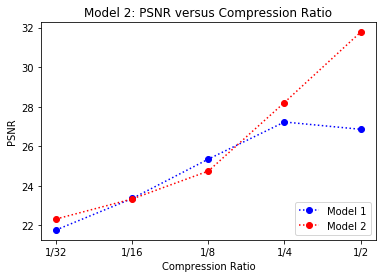

In [12]:
# Calculate average PSNR
model1_PSNRs = []
for d_img in model1_decoded_images:
    model1_PSNRs.append(vcompresslib.get_psnr(test_image, d_img))
    
model2_PSNRs = []
for d_img in model2_decoded_images:
    model2_PSNRs.append(vcompresslib.get_psnr(test_image, d_img))


# Giving a title to the graph 
plt.title('Model 2: PSNR versus Compression Ratio') 

plt.plot(ratios, model1_PSNRs, 'bo:', label = 'Model 1')
plt.plot(ratios, model2_PSNRs, 'ro:', label = 'Model 2')
plt.xlabel('Compression Ratio')
plt.ylabel('PSNR')
plt.legend(loc = 4)

plt.show()

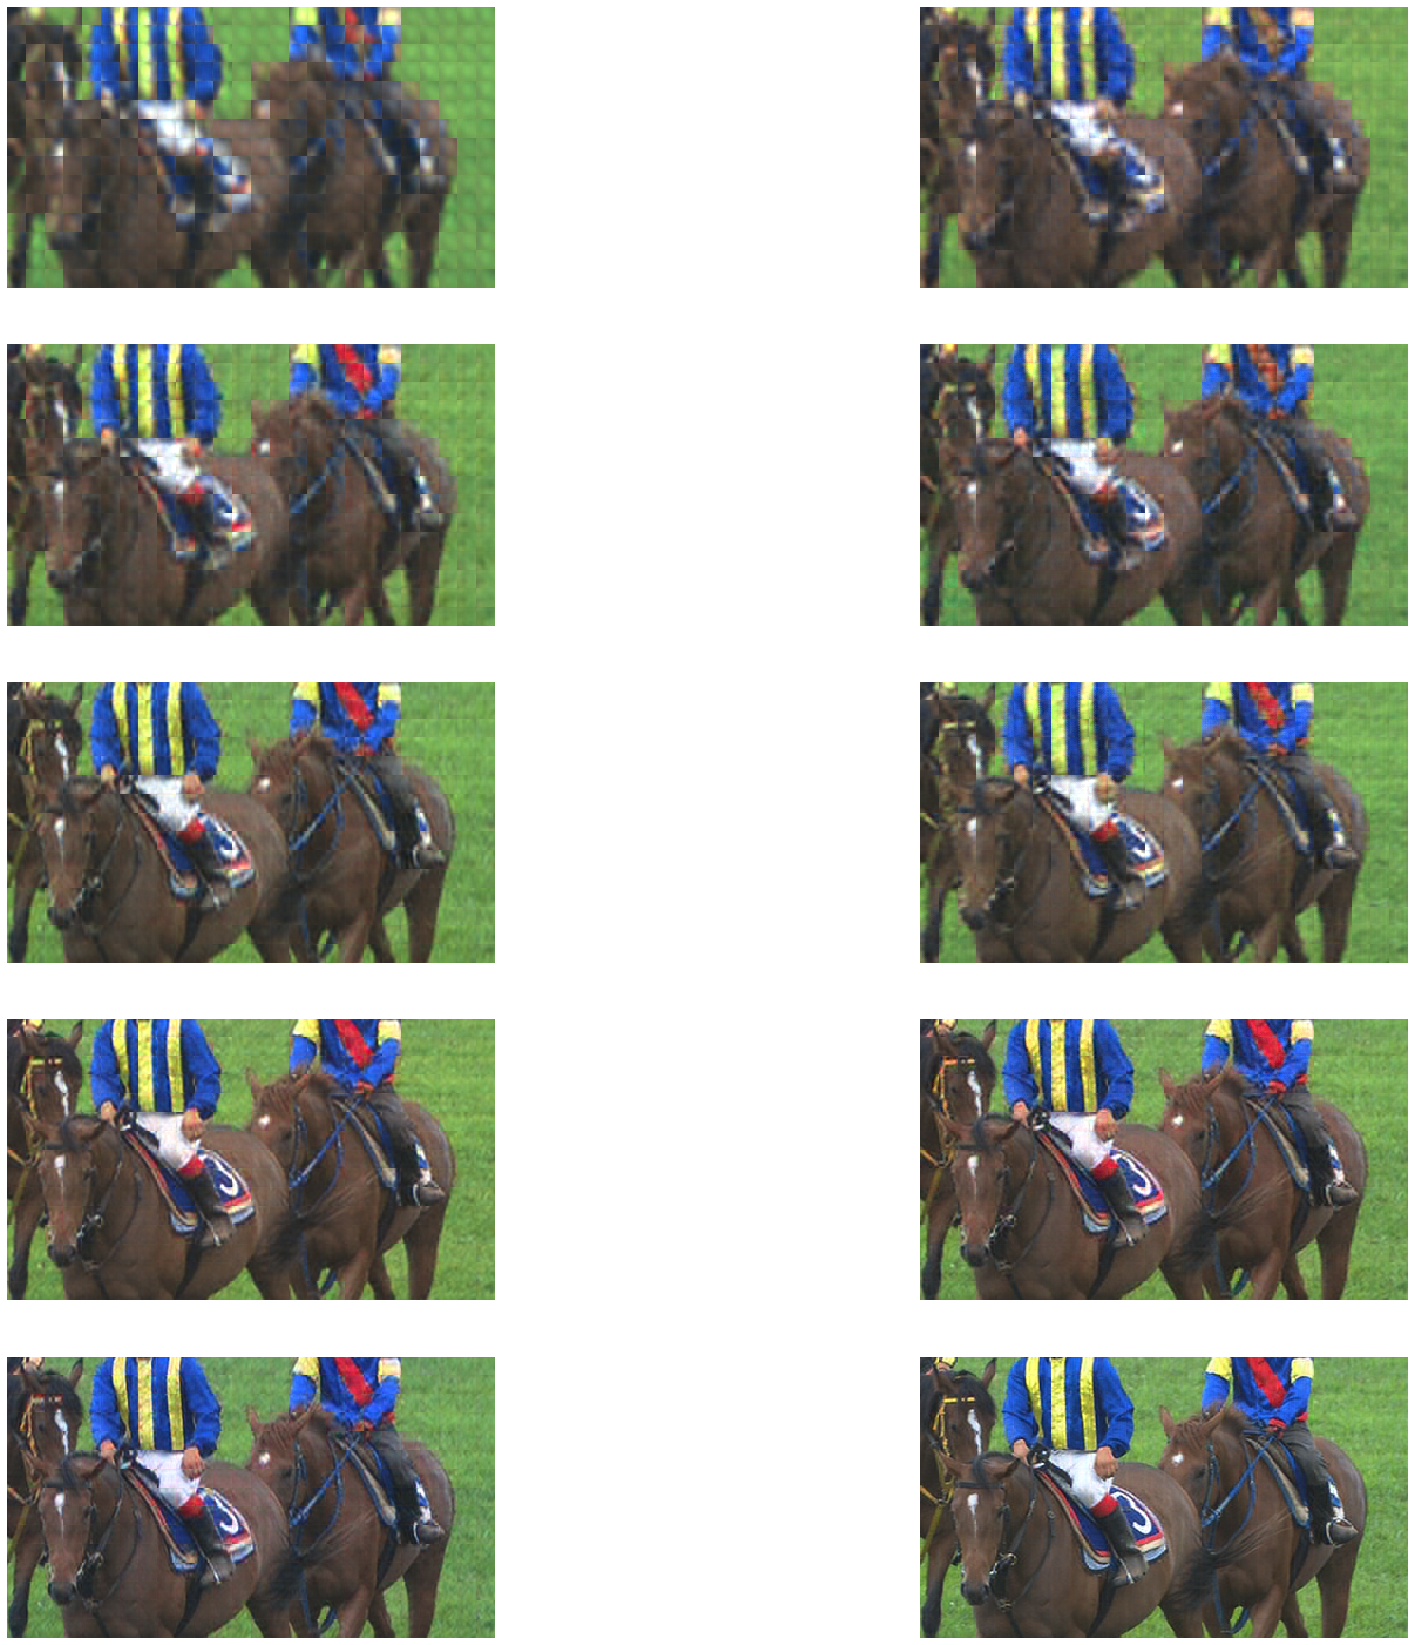

In [14]:
n_images = 5

_, axarr = plt.subplots(n_images, 2,figsize=(30, 30), sharey=True)


for i in range(n_images):
        axarr[i, 0].imshow(model1_decoded_images[i][5])
        axarr[i, 1].imshow(model2_decoded_images[i][5])
        axarr[i, 0].axis('off')
        axarr[i, 1].axis('off')

plt.show()